In [1]:
source("Main.R")
source("Conf.R")
source("Utilities.R")
library("stringr")

corrplot 0.92 loaded

Warning message:
“package ‘ggplot2’ was built under R version 4.2.2”

Attaching package: ‘pls’


The following object is masked from ‘package:corrplot’:

    corrplot


The following object is masked from ‘package:stats’:

    loadings


Warning message:
“package ‘data.table’ was built under R version 4.2.2”

Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


Warning message:
“package ‘stringr’ was built under R version 4.2.2”


In [2]:
combosObserved <- readRDS( paste0(projectDir,"/Notebooks/CombinatorialPerturbations/RDSFiles/ComboEffects_lm_residuals.rds"))
combosObserved <- combosObserved[combosObserved$term %ni% c("(Intercept)", "n_genes", "mt_frac", paste0("leiden", 1:9)),]
combosObserved[,c("std.error", "statistic", "p.value")] = NULL
combosObserved$term <- sapply(combosObserved$term, function(x){str_replace_all(x, "_", "")})
colnames(combosObserved) = c("Group", "ObservedLogFCEstimate", "respGene")

# combosObservedPval <- readRDS(paste0(projectDir, "./RDSFiles/ComboEffects_lm_residuals.rds"))
# combosObservedPval <- readRDS(paste0(projectDir, "./RDSFiles/ComboEffects_lm_residuals.rds"))
# combosObservedPval <- combosObservedPval[combosObservedPval$term %ni% c("(Intercept)", "n_genes", "mt_frac", paste0("leiden", 1:9)),]
# combosObservedPval[,c("std.error", "statistic", "estimate")] = NULL
# combosObservedPval$term <- sapply(combosObservedPval$term, function(x){str_replace_all(x, "_", "")})
# colnames(combosObservedPval) = c("Group", "Pvalue", "respGene")
# head(combosObservedPval)

combosInterP <- readRDS(paste0(projectDir,"/Notebooks/CombinatorialPerturbations/RDSFiles/ComboEffects_lm_residuals_withInteractions.rds") )
combosInterP <- combosInterP[combosInterP$term %ni% c("(Intercept)", "n_genes", "mt_frac", paste0("leiden", 1:9)),]
combosInterP = data.table(combosInterP)
combosInterP[,FDR:=p.adjust(p.value, method = "fdr", n = length(p.value)),by=respGene]
combosInterP = data.frame(combosInterP)
combosInterP$term <- sapply(combosInterP$term, function(x){str_replace_all(as.character(x),"_","")})
combosInterP$term <- sapply(combosInterP$term, function(x){str_replace_all(as.character(x),":","W")})
combosInterP <- combosInterP[,c("term", "FDR", "respGene")]
colnames(combosInterP) = c("Group", "FDRInteraction", "respGene")
combosObserved = merge(combosObserved,combosInterP, by=c("Group", "respGene"))


In [3]:
head(combosObserved)

,Group,respGene,ObservedLogFCEstimate,FDRInteraction
,<chr>,<chr>,<dbl>,<dbl>
1,K0,0610012G03Rik,-0.025557392,0.2101959
2,K0,2010005H15Rik,-0.013252338,0.3476098
3,K0,2010111I01Rik,0.013136786,0.5057520
4,K0,2310001H17Rik,-0.008150180,0.8604282
5,K0,2810474O19Rik,0.006997083,0.7907135
6,K0,AA467197,0.004630521,0.7298299


In [3]:
allResDF = read.csv(paste0(projectDir,"/Notebooks/CombinatorialPerturbations/outputs/K_singles/model_alpha_1_v5/PredictedFC_Coef.csv"))

allResDF = allResDF[allResDF$X != "intercept",]
allResDF = melt(allResDF)
colnames(allResDF) = c("Group","respGene","PredictedLogFCEstimate")
allResDF$Group = sapply(allResDF$Group, function(x){strsplit(x, "perturb_")[[1]][2]})
allResDF$Group = sapply(allResDF$Group, function(x){str_replace(x, "_", "W")})

allRes = merge(combosObserved, allResDF , by=c("Group", "respGene"))
allRes = data.table(allRes)
allRes[,R2:=round(computeR2(response = ObservedLogFCEstimate, prediction = PredictedLogFCEstimate), digits=2),by=Group]
allRes[,MAE:=round(mean(abs(PredictedLogFCEstimate - ObservedLogFCEstimate )), digits=2),by=Group]
allRes = data.frame(allRes)

allRes$Group1 = sapply(allRes$Group, function(x){return(strsplit(as.character(x),"W")[[1]][1]) })
allRes$Group2 = sapply(allRes$Group, function(x){return(strsplit(as.character(x),"W")[[1]][2]) })
allRes$ObsPredDif = allRes$ObservedLogFCEstimate - allRes$PredictedLogFCEstimate
allRes$AbsObsPredDif = abs(allRes$ObservedLogFCEstimate - allRes$PredictedLogFCEstimate)
allRes$GroupGene = paste0(allRes$Group,"_",allRes$respGene)
allRes[is.na(allRes$Group2),"Group2"] = allRes[is.na(allRes$Group2),"Group1"]
    

1

Using X as id variables



[1] 1

Warning message:
“Removed 2 rows containing missing values (geom_point).”


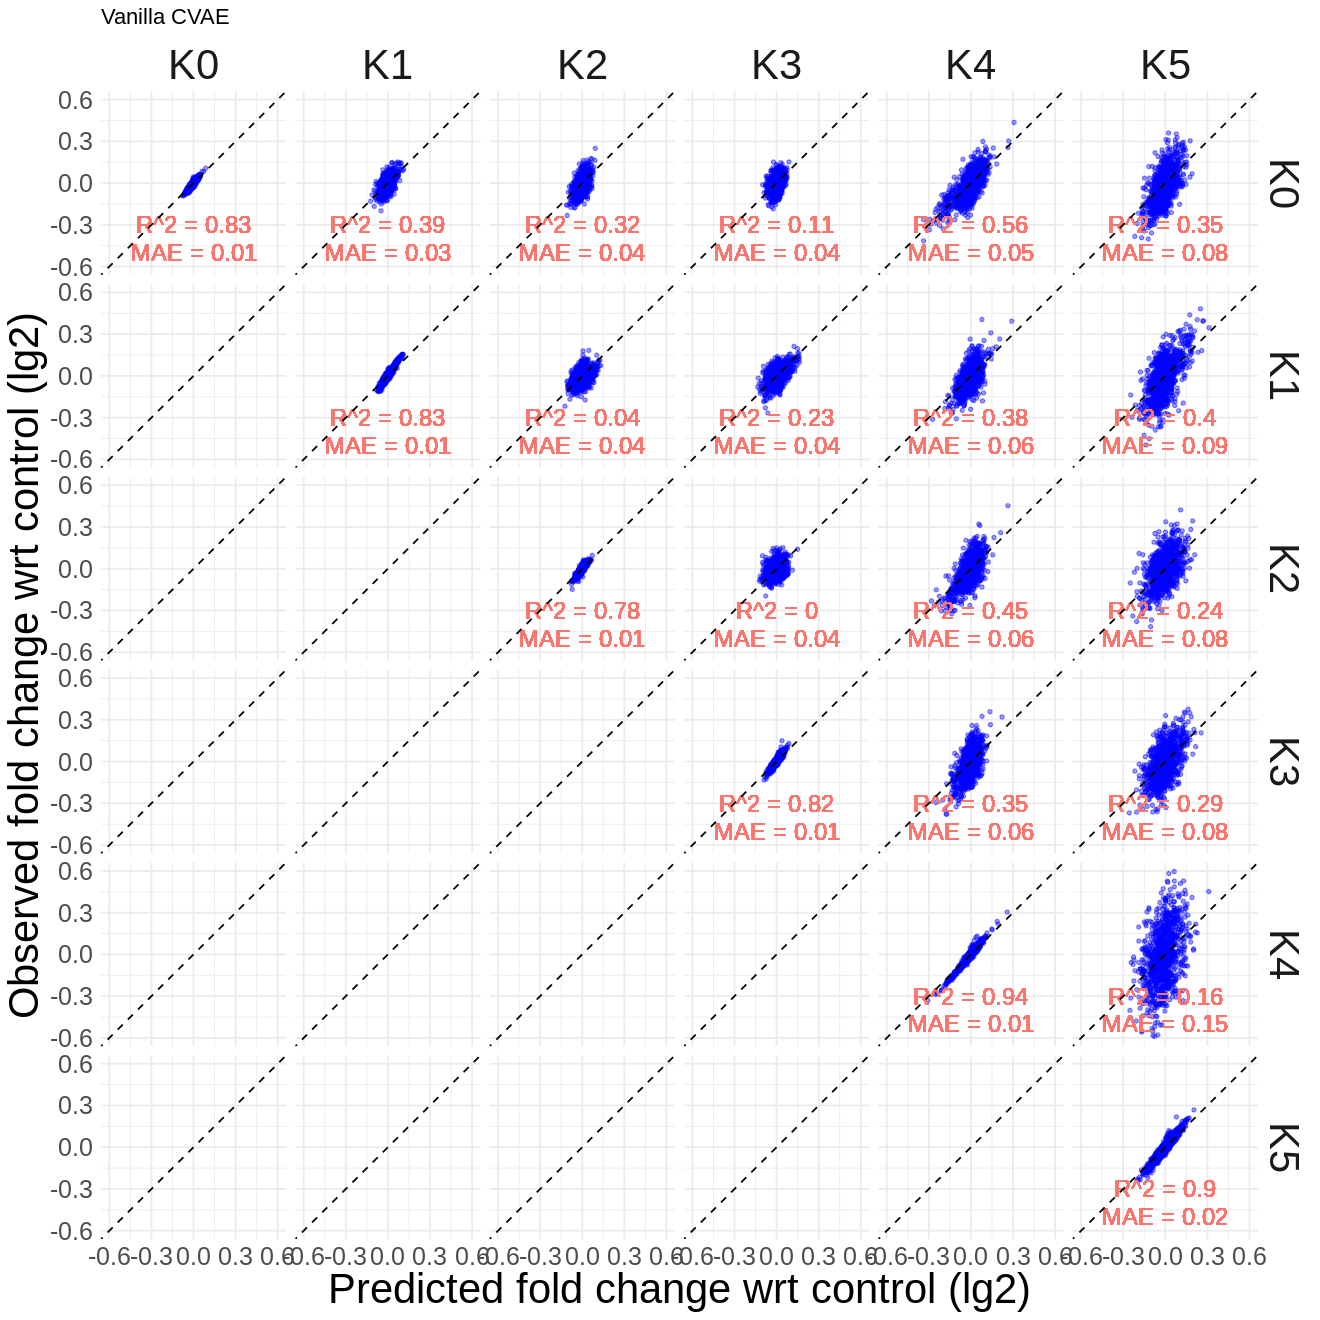

In [4]:
options(repr.plot.width=11, repr.plot.height=11)

allRes[allRes$R2 < 0,"R2"] = 0

#pdf("./../SupplementaryFigures/S_6I.pdf", width=12, height=12)
print(ggplot(allRes, aes(x=PredictedLogFCEstimate, y=ObservedLogFCEstimate)) + 
    geom_point(alpha=0.4, shape=20, color="blue") + 
    facet_grid(Group1 ~ Group2)+
    geom_text(aes(label= paste0("R^2 = ",R2), color="red"), x=0, y=-0.3, size=5)+
    geom_text(aes(label= paste0("MAE = ",MAE), color="red"), x=0, y=-0.5, size=5)+
    geom_abline(linetype="dashed")+
    theme_minimal()+
    theme(axis.text = element_text(size = 15),
          axis.title = element_text(size = 25),
          strip.text = element_text(size = 25), legend.position='none')+
    xlim(-0.6,0.6)+ylim(-0.6,0.6)+
    ylab("Observed fold change wrt control (lg2)")+
    xlab("Predicted fold change wrt control (lg2)")+ggtitle("Vanilla CVAE"))

#dev.off()

Warning message:
“Removed 17 rows containing missing values (geom_point).”


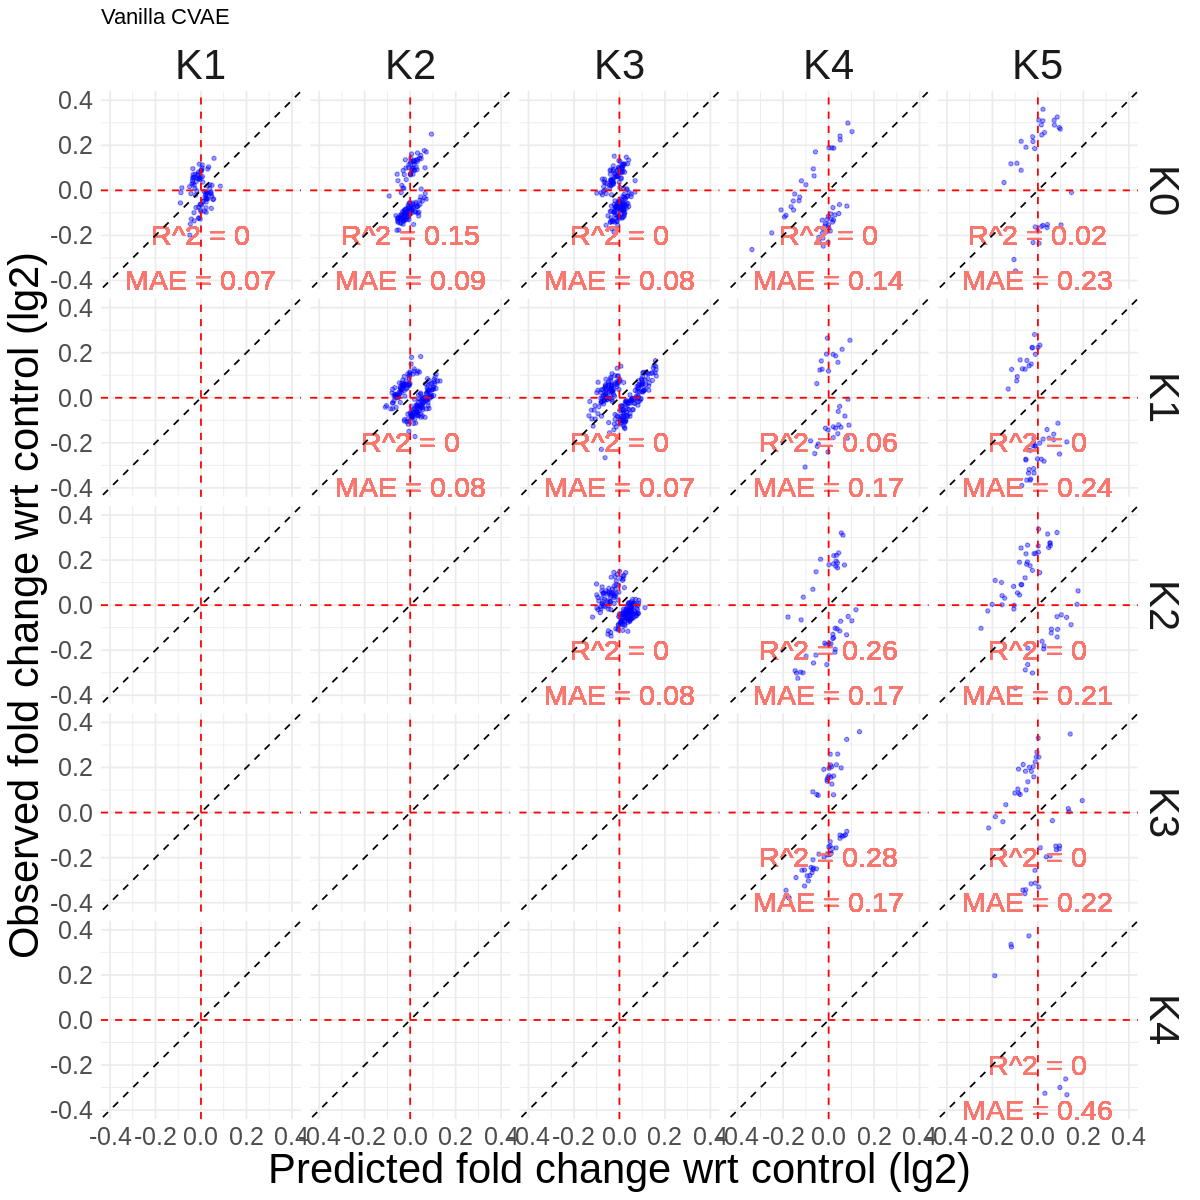

In [5]:
geneDE = allRes[allRes$Group %ni% c("K0", "K1", "K2", "K3", "K4", "K5"),]
geneDE = geneDE[geneDE$FDRInteraction < 0.1,]
geneDE = data.table(geneDE)

geneDE[,SignR2 := round(computeR2(response = ObservedLogFCEstimate, prediction = PredictedLogFCEstimate), digits = 2),by=Group]
geneDE[,SignMAE:=round(mean(abs(PredictedLogFCEstimate - ObservedLogFCEstimate )), digits=2),by=Group]

geneDE[geneDE$SignR2 < 0,"SignR2"] = 0

options(repr.plot.width=10, repr.plot.height=10)
#pdf("./../SupplementaryFigures/S_6K.pdf", width=12, height=12)
print(ggplot(geneDE, aes(x=PredictedLogFCEstimate, y=ObservedLogFCEstimate)) + 
    geom_point(alpha=0.4, shape=20, color="blue") + 
    facet_grid(Group1 ~ Group2)+
    geom_text(aes(label= paste0("R^2 = ",SignR2), color="red"), x=0, y=-0.2, size=6)+
    geom_text(aes(label= paste0("MAE = ",SignMAE), color="red"), x=0, y=-0.4, size=6)+
    geom_abline(linetype="dashed")+
    theme_minimal()+
    theme(axis.text = element_text(size = 15),
          axis.title = element_text(size = 25),
          strip.text = element_text(size = 25), legend.position='none')+
    geom_vline(xintercept = 0, linetype="dashed", color="red")+
    geom_hline(yintercept = 0, linetype="dashed", color="red")+
    xlim(-0.4,0.4)+ylim(-0.4,0.4)+
    ylab("Observed fold change wrt control (lg2)")+
    xlab("Predicted fold change wrt control (lg2)")+ggtitle("Vanilla CVAE"))
#dev.off()

Warning message:
“Removed 1 rows containing missing values (geom_point).”


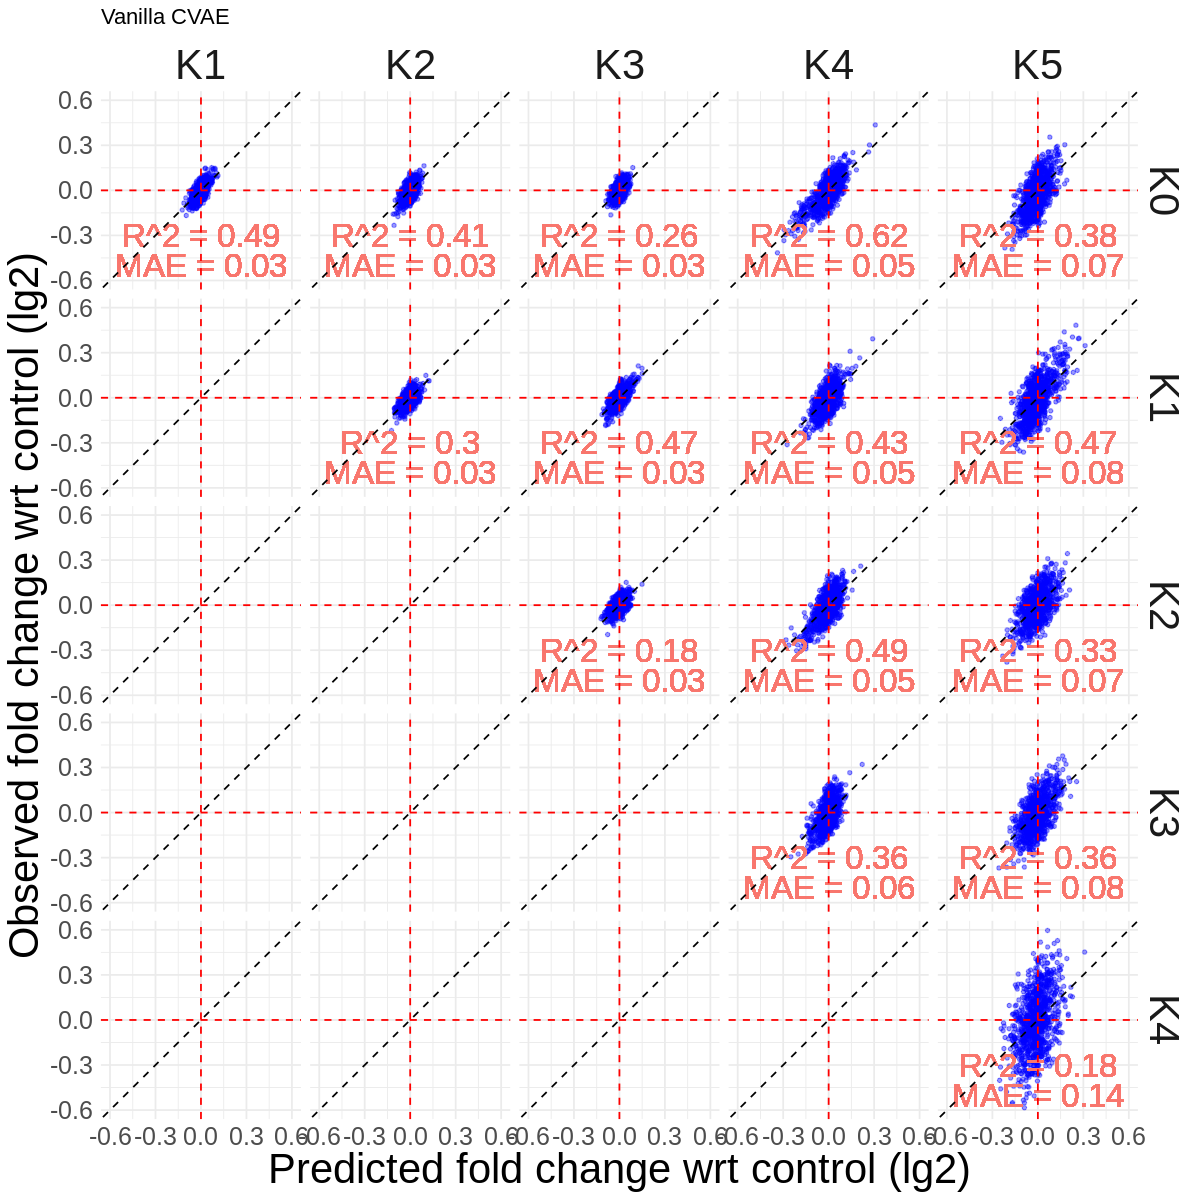

In [6]:
geneDE = allRes[allRes$Group %ni% c("K0", "K1", "K2", "K3", "K4", "K5"),]
geneDE = geneDE[geneDE$FDRInteraction >= 0.1,]
geneDE = data.table(geneDE)

geneDE[,SignR2 := round(computeR2(response = ObservedLogFCEstimate, prediction = PredictedLogFCEstimate), digits = 2),by=Group]
geneDE[,SignMAE:=round(mean(abs(PredictedLogFCEstimate - ObservedLogFCEstimate )), digits=2),by=Group]

geneDE[geneDE$SignR2 < 0,"SignR2"] = 0

options(repr.plot.width=10, repr.plot.height=10)

print(ggplot(geneDE, aes(x=PredictedLogFCEstimate, y=ObservedLogFCEstimate)) + 
    geom_point(alpha=0.4, shape=20, color="blue") + 
    facet_grid(Group1 ~ Group2)+
    geom_text(aes(label= paste0("R^2 = ",SignR2), color="red"), x=0, y=-0.3, size=7)+
    geom_text(aes(label= paste0("MAE = ",SignMAE), color="red"), x=0, y=-0.5, size=7)+
    geom_abline(linetype="dashed")+
    theme_minimal()+
    theme(axis.text = element_text(size = 15),
          axis.title = element_text(size = 25),
          strip.text = element_text(size = 25), legend.position='none')+
    geom_vline(xintercept = 0, linetype="dashed", color="red")+
    geom_hline(yintercept = 0, linetype="dashed", color="red")+
    xlim(-0.6,0.6)+ylim(-0.6,0.6)+
    ylab("Observed fold change wrt control (lg2)")+
    xlab("Predicted fold change wrt control (lg2)")+ggtitle("Vanilla CVAE"))




In [7]:
models= read.csv(paste0(projectDir, "/TextFiles/ComboKOModels.csv"))
head(models)

,Model_Name,Alpha,ComboIncluded,SubFolder
,<chr>,<dbl>,<int>,<chr>
1,model_alpha_0_1_v1,0.1,0,K_singles
2,model_alpha_0_1_v2,0.1,0,K_singles
3,model_alpha_0_1_v3,0.1,0,K_singles
4,model_alpha_0_1_v4,0.1,0,K_singles
5,model_alpha_0_1_v5,0.1,0,K_singles
6,model_alpha_0_1_v6,0.1,0,K_singles


In [8]:
options(repr.plot.width=12, repr.plot.height=12)
allR2s = data.frame()
allSgnR2s = data.frame()

for( i in 1:nrow(models)){

    if(models[i,"SubFolder"] == "K_singles" & models[i,"Alpha"] == 1){
        allResDF = read.csv(paste0(projectDir,"/Notebooks/CombinatorialPerturbations/outputs/", models[i,"SubFolder"], "/",models[i,"Model_Name"],"/PredictedFC_Coef.csv"))


        allResDF = allResDF[allResDF$X != "intercept",]
        allResDF = melt(allResDF)
        colnames(allResDF) = c("Group","respGene","PredictedLogFCEstimate")
        allResDF$Group = sapply(allResDF$Group, function(x){strsplit(x, "perturb_")[[1]][2]})
        allResDF$Group = sapply(allResDF$Group, function(x){str_replace(x, "_", "W")})



        allRes = merge(combosObserved, allResDF , by=c("Group", "respGene"))
        allRes = data.table(allRes)
        allRes[,R2:=round(computeR2(response = ObservedLogFCEstimate, prediction = PredictedLogFCEstimate), digits=2),by=Group]
        allRes[,MAE:=round(mean(abs(PredictedLogFCEstimate - ObservedLogFCEstimate )), digits=2),by=Group]
        allRes = data.frame(allRes)

        #head(allResDF, n=50)

        allRes$Group1 = sapply(allRes$Group, function(x){return(strsplit(as.character(x),"W")[[1]][1]) })
        allRes$Group2 = sapply(allRes$Group, function(x){return(strsplit(as.character(x),"W")[[1]][2]) })
        allRes$ObsPredDif = allRes$ObservedLogFCEstimate - allRes$PredictedLogFCEstimate
        allRes$AbsObsPredDif = abs(allRes$ObservedLogFCEstimate - allRes$PredictedLogFCEstimate)
        allRes$GroupGene = paste0(allRes$Group,"_",allRes$respGene)
        allRes[is.na(allRes$Group2),"Group2"] = allRes[is.na(allRes$Group2),"Group1"]

        myTmp = unique(allRes[,c("R2","MAE","Group1","Group2")])
        myTmp$Model = models[i,"Model_Name"]

    
        allR2s = rbind(allR2s, myTmp)

    }
}

Using X as id variables

Using X as id variables

Using X as id variables

Using X as id variables

Using X as id variables

Using X as id variables

Using X as id variables



In [9]:
allR2s$GroupPair = paste0(allR2s$Group1,"_",allR2s$Group2)
head(allR2s)

,R2,MAE,Group1,Group2,Model,GroupPair
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,0.78,0.01,K0,K0,model_alpha_1_v1,K0_K0
1026,0.32,0.03,K0,K1,model_alpha_1_v1,K0_K1
2051,0.29,0.04,K0,K2,model_alpha_1_v1,K0_K2
3076,0.08,0.04,K0,K3,model_alpha_1_v1,K0_K3
4101,0.52,0.06,K0,K4,model_alpha_1_v1,K0_K4
5126,0.33,0.08,K0,K5,model_alpha_1_v1,K0_K5


In [11]:
unique(allR2s$Model)

[1] "model_alpha_1_v1" "model_alpha_1_v2" "model_alpha_1_v3" "model_alpha_1_v4"
[5] "model_alpha_1_v5" "model_alpha_1_v6" "model_alpha_1_v7"

In [10]:
allR2sMelted = melt(allR2s[,c("R2","MAE","GroupPair")])

Using GroupPair as id variables



In [12]:
options(repr.plot.width=6, repr.plot.height=6)

pdf("./../SupplementaryFigures/S_6J.pdf", width=6, height=6)
ggplot(data=allR2sMelted, aes(x=GroupPair, y=value, fill=GroupPair)) +
  facet_wrap(~variable, scales="free_y", ncol = 1)+
  geom_boxplot()+
  theme_bw()+theme(axis.text.x = element_text(size = 15, angle=90),
                   axis.text.y = element_text(size = 25),
                   axis.title = element_text(size = 25),
                   strip.text=element_text(size = 25),
                   legend.position="none")+ylab("Value")+
                   xlab("Group pairs")
dev.off()

png 
  2